# PatternNet Classification using ViT

### Importing required libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

from torchvision import datasets, transforms, models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.utils import save_image
from torchvision import datasets
from torchsummary import summary

import spacy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import math
from PIL import Image
import glob
from IPython.display import display
from tensorflow import keras

### Changing device from CPU to GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [5]:
BATCH_SIZE = 32
LR = 5e-5
NUM_EPOCHES = 15

In [6]:
mean, std = (0.5,), (0.5,)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std),
                              ])

### Loading dataset from image folder

In [7]:
train_data = datasets.ImageFolder('images',transform=transform)

In [8]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
trainloader.dataset

Dataset ImageFolder
    Number of datapoints: 30400
    Root location: images
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [10]:
for img, label in trainloader:
    print(img[10].shape)
    break

torch.Size([3, 256, 256])


### Importing ViT module

In [11]:
from transformer_package.models import ViT

In [12]:
image_size = 256
channel_size = 1
patch_size = 128
embed_size = 512
num_heads = 8
classes = 38
num_layers = 3
hidden_size = 512
dropout = 0.2

model = ViT(image_size, channel_size, patch_size, embed_size, num_heads, classes, num_layers, hidden_size, dropout=dropout).to(device)
model

ViT(
  (dropout_layer): Dropout(p=0.2, inplace=False)
  (embeddings): Linear(in_features=16384, out_features=512, bias=True)
  (encoders): ModuleList(
    (0-2): 3 x VisionEncoder(
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.2, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (mlp): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.2, inplace=False)
        (3): Linear(in_features=2048, out_features=512, bias=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (norm):

In [13]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR)

### Training the model

In [14]:
loss_hist = {}
loss_hist["train accuracy"] = []
loss_hist["train loss"] = []

for epoch in range(1, NUM_EPOCHES+1):
    model.train()
    
    epoch_train_loss = 0
        
    y_true_train = []
    y_pred_train = []
        
    for batch_idx, (img, labels) in enumerate(trainloader):
        t = transforms.Grayscale()
        img = t(img)
        img = img.to(device)
        labels = labels.to(device)
        
        preds = model(img)
        
        loss = criterion(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        y_pred_train.extend(preds.detach().argmax(dim=-1).tolist())
        y_true_train.extend(labels.detach().tolist())
          
        epoch_train_loss += loss.item()
    
    loss_hist["train loss"].append(epoch_train_loss)
    
    total_correct = len([True for x, y in zip(y_pred_train, y_true_train) if x==y])
    total = len(y_pred_train)
    accuracy = total_correct * 100 / total
    
    loss_hist["train accuracy"].append(accuracy)
    
    print("-------------------------------------------------")
    print("Epoch: {} Trainx mean loss: {:.8f}".format(epoch, epoch_train_loss))
    print("       Train Accuracy%: ", accuracy, "==", total_correct, "/", total)
    print("-------------------------------------------------")

-------------------------------------------------
Epoch: 1 Train mean loss: 2602.78385711
       Train Accuracy%:  22.901315789473685 == 6962 / 30400
-------------------------------------------------
-------------------------------------------------
Epoch: 2 Train mean loss: 2099.58744502
       Train Accuracy%:  35.11842105263158 == 10676 / 30400
-------------------------------------------------
-------------------------------------------------
Epoch: 3 Train mean loss: 1886.67140865
       Train Accuracy%:  41.26315789473684 == 12544 / 30400
-------------------------------------------------
-------------------------------------------------
Epoch: 4 Train mean loss: 1707.58974564
       Train Accuracy%:  46.19078947368421 == 14042 / 30400
-------------------------------------------------
-------------------------------------------------
Epoch: 5 Train mean loss: 1551.06897843
       Train Accuracy%:  50.76973684210526 == 15434 / 30400
-------------------------------------------------


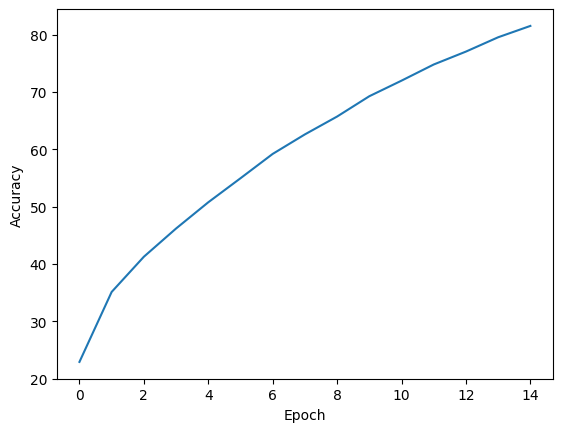

In [15]:
plt.plot(loss_hist["train accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()